In [12]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline

# Part 1 - Object Blending

### Sliding Window Object for Bilinear Kernel

In [13]:
class Window:
    
    def __init__(self, image, n, p):
        
        self.xlimit = image.shape[1]+n
        self.ylimit = image.shape[0]+n
        self.topleft = (0,0)
        self.bottomright = (n,n)
        self.prev = n
        self.height = n
        self.pace = (p, p)
        
        try:
            self.channels = image.shape[2]
        except:
            self.channels = 1
            
    #------------------------------
    #Gets the current Position of the Window
            
    def Position(self):
        
        return self.topleft, self.bottomright
    
    #------------------------------
    #Returns the next values regarding the next position of the window, where the window can either 
    #drop to a new line or simply move on pixel to the right
    
    def NextPosition(self):
        
        #New Line Movement
        if(self.bottomright + self.pace)[0] >= (self.xlimit - self.height):
            return (0, self.topleft[1] + self.pace[1]), (self.height, self.bottomright[1] + self.pace[1])
        
        #Moving one pixel to the Right
        else:
            return (self.topleft[0] + self.pace[0], self.topleft[1]), (self.bottomright[0] + self.pace[0], self.bottomright[1])
        
    #------------------------------
    #Operates on the NextPosition return to return the new value after movement
        
    def NextMove(self):
        
        #Move Position of Window
        self.topleft, self.bottomright = self.NextPosition()
        return self.topleft, self.bottomright
    
    #------------------------------
    #Checks whether the current coordinates of the sliding window are in bounds of the image or not
    
    def InBounds(self, templeft = None, tempright = None):
        
        if templeft is None:
            templeft = self.topleft
        if tempright is None:
            tempright = self.bottomright 
            
        return tempright[0] <= self.xlimit and tempright[1] <= self.ylimit and templeft[0] >= 0 and templeft[1] >= 0
    
    #------------------------------
    #Checking if the y coordinate of the bottom right corner has changed or not
    
    def newY(self):
        
        if self.prev == self.bottomright[1]:
            return False
        
        else:
            
            self.prev = self.bottomright[1]
            return True
        
    #------------------------------
    #
        
    def getImgBounds(self, image):
        
        img = []
        
        for i in range(self.topleft[1], self.bottomright[1]):
            
            if i >= image.shape[0]:
                continue
                
            img.append(image[i][self.topleft[0]: self.bottomright[0]])
            
        if self.channels == 1:
            
            return np.resize(np.array(img), (self.height, self.height)) #self.height twice since square
        
        else:
            
            return np.resize(np.array(img), (self.height, self.height, self.channels))


class Kernel:
    
    def __init__(self, kernel, weight):
        
        self.kernel = kernel
        self.weight = weight 
        
    def Filter(self, roi, axis = 0, channels = 1):
        
        output = []
        
        if axis == 2:
            
            #Loop over each channel
            for i in range(channels):
                
                #Multiplying with the RoI pixels with the kernel
                if channels == 1:
                    _filter = self.kernel * roi
                
                else:
                    _filter = self.kernel * roi[:, :, i]
                
                #Summing the values
                filsum = _filter.sum()
                
                if channels == 1:
                    _filter = self.kernel.T * roi
                
                else:
                    
                    _filter = self.kernel.T * roi[:, :, i]
                    
                filsum2 = _filter.sum()
                
                #Appending to a list 'Output'
                output.append((((filsum**2) + (filsum2 **2)) ** (1/2)) * self.weight)
                
            return np.array(output)
        
        else:
            
            if axis == 0:
                kernel = self.kernel 
            else:
                self.kernel.T
             
            #Loop over each channel
            for i in range(channels):
                
                #Multiplying with the RoI pixels with the kernel
                if channels == 1:
                    _filter = kernel * roi
                
                else:
                    _filter = kernel * roi[:, :, i]
                
                #Summing and Appending the Values 
                output.append(_filter.sum() * self.weight)
                
            return np.array(output)
        
        
    #Filters the image like an RoI by sliding a window
        
    def FilterImage(self, image, pace = 1, window = None, axis = 0):
        
        img = [] #Output
        line = [] #Line of Pixels
        
        #--------------------------
        #Validating Window
        if window is None:
            
            move = Window(image, self.kernel.shape[0], pace) #Generating a Window Object
            
        else:
            
            image = window.getImgBounds(image)
            move = Window(image, self.kernel.shape[0], pace)
            
        topleft, _ = move.NextPosition()
        
        #-------------------------
        #Operations when Filtering 
        while move.InBounds(topleft):
            
            roi = move.getImgBounds(image)
            
            if move.newY():
                img.append(line)
                line = []
                
            line.append(self.Filter(roi, axis, move.channels))
            
            #--------------------
            #Preparing the Window for the next iteration
            move.NextMove()
            topleft, _ = move.NextPosition() 
            
        return np.array(img) #Returning the Image as an array of Pixels
    
    
class Bilinear:    
    def __init__(self, weight):
        self.kernel = Kernel(np.array([[1, 2, 1],
                                       [2, 4, 2],
                                       [1, 2, 1]]), weight)

    def FilterImage(self, image, pace = 1, window = None, axis = 0):
        return self.kernel.FilterImage(image, pace, window, axis)

### Sobel and Gaussian Kernels

In [14]:

# Sliding window
def sliding_window(image, n, s, show=False):
    height, width = image.shape[0:2]
    
    for i in range(0, height-n+1, s):
        for j in range(0, width-n+1, s):
            if show:
                yield (j, i, j+n, i+n) # Used to plot rectangle
            elif show==False:
                yield image[i:i+n, j:j+n] # Current image region

# Generate a sobel kernel of n*n dimension
def gen_sobel(n, trans=False):
    sobel = np.zeros((n,n)) # initial array of 0s
    centre = n/2 - 0.5
    for i in range(n):
        for j in range(n):
            # Skips the middle pixel (which is always 0) 
            # to avoid divide by 0 errors
            if i==centre and j==centre:
                continue
                
            x = i - centre # x distance from centre
            y = j - centre # y distance from centre
            sobel[j, i] = x / (x*x + y*y) 
    if trans: return np.transpose(sobel)
    return sobel

# Generating Gaussian kernel
def gen_gaussian(size, fwhm = 10, center=None):
    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]
    if center is None:
        x0 = y0 = size // 2 # Centre is identified as the centre pixel
    else:
        x0 = center[0]
        y0 = center[1]
    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2) # Gaussian equation


def convolve(region, kernel):
    # Valid region and filter dimensions
    if region.shape[0] == region.shape[1] == kernel.shape[0] == kernel.shape[1]:
        pix = [sum(sum(region[:, :, i]*kernel)) for i in range(3)] # Convolution operation
        return pix
    else:
        raise Exception('Invalid kernel and/or region sizes')

# Convolution logic and display before and after pics

def convolve_image(image, kernel, stride):
    
    n = kernel.shape[0]
    img_height, img_width = image.shape[0:-1]
    
    # New height and width of convolution output
    width = int((img_width - n) / stride) +1 
    height = int((img_height - n) / stride)+1
    
    convolved_img = np.zeros((height, width, 3))
    regions = list(sliding_window(image, n, stride))
    
    # Populating output with convolved pixel values
    count=0
    for i in range(height):
        for j in range(width):
            convolved_img[i][j] = convolve(regions[count], kernel)
            count+=1
    
    # Convolved image output pixels are normalised between 0 and 255 and converted to integer
    norm = np.zeros((1,1))
    return cv2.normalize(convolved_img, norm, 0, 255, cv2.NORM_MINMAX).astype(int)

#sobel_x_img = convolve_image(img, gen_sobel(3), 1)
#sobel_y_img = convolve_image(img, gen_sobel(3, True), 1)

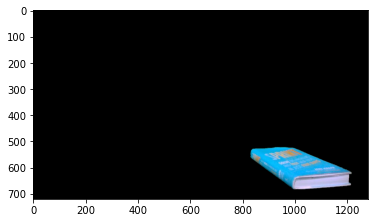

In [15]:
S2 = cv2.imread('COTSDataset/Part 2 - Multiple Objects/academic_book_no/3_colour.jpeg')
mask = cv2.imread('COTSDataset/Part 2 - Multiple Objects/academic_book_no/masks/ac_3_colour_mask_8_mask.png')


extracted = ExtractObject(S2, mask)
plt.imshow(extracted[:,:,::-1])

## Functions for Object Blending

In [16]:
def ExtractObject(S2, Mask):
    return cv2.bitwise_and(S2, Mask)

def ApplyFilter(Object, Filter):
    
    if Filter == 0:
        return Object
    elif Filter == 1:
        # Sobel X
        return convolve_image(Object, gen_sobel(3, False), 1)
    elif Filter == 2:
        # Gaussian
        return convolve_image(Object, gen_gaussian(10), 3)
    elif Filter == 3:
        #Bilinear
        bilinear = Bilinear(1/10)
        FilteredObject = bilinear.FilterImage(Object, axis=0)
        return FilteredObject
    else:
        print("[ERR]Incorrect Input")
        return 0

def ObjectBlender(S1, FilteredExObject):
    gray = cv2.cvtColor(FilteredExObject, cv2.COLOR_BGR2GRAY)
    ret,mask = cv2.threshold(gray,0,255,cv2.THRESH_BINARY)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    background = cv2.bitwise_and(S1, cv2.bitwise_not(mask))
    return FilteredExObject+background
    
def CompareResult(BlendingResult, S2, metric):
    return

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


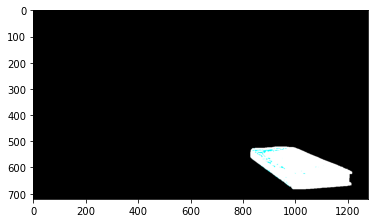

In [17]:
filteredImg = ApplyFilter(extracted, 3)
plt.imshow(filteredImg[:,:,::-1])

(720, 1280, 3)


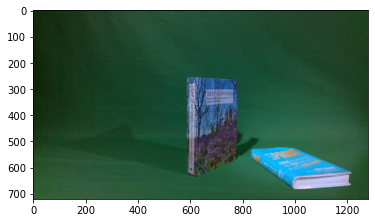

In [18]:
S1 = cv2.imread('COTSDataset/Part 2 - Multiple Objects/academic_book_no/1_colour.jpeg')
print(S1.shape)
blend = ObjectBlender(S1, extracted)
plt.imshow(blend[:,:,::-1])

### SSD - Sum of Square Differences 

In [49]:
def SSD(x, y):
    dif = x.ravel() - y.ravel()
    return np.dot(dif, dif)

print("SSD of Blend and S2: ", SSD(blend, S2))

SSD of Blend and S2:  182


### MSE - Mean Squared Error

In [51]:
MSE = np.square(np.subtract(blend,S2)).mean()
print("MSE of Blend and S2: ", MSE)

MSE of Blend and S2:  28.089695457175925


# Part 2 - Image Inpainting

### Removing Green Background from Image

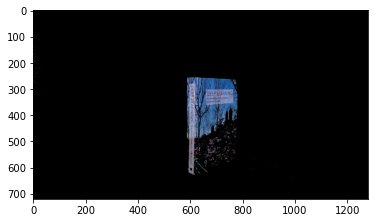

In [47]:
def RemoveGreen(img):
    
    lower_green = np.array([0, 35, 0]) 
    upper_green = np.array([90, 255, 90]) 
    
    mask = cv2.inRange(img, lower_green, upper_green)
    skd = np.copy(img)
    skd[mask!=0] = [0,0,0]
    
    return skd

masked = RemoveGreen(S1)
plt.imshow(masked[:,:,::-1])

### Blending Extracted Image to a New Background

In [42]:
def NewBackground(imgNoBg, NewBackground):
    final = imgNoBg + NewBackground
    #plt.imshow(final)
    return final

### Application
Iterating through all of the backgrounds and blending a

In [43]:
for x in os.listdir("ResizedBGS"):
    image = cv2.imread("ResizedBGS/" + x)
    final = NewBackground(masked, image)
    #cv2.imshow("Output", final)
    cv2.imwrite("Output/green" + x, final, [cv2.IMWRITE_PNG_COMPRESSION, 0])